# Errors and uncertainty in simulations

Philipp Schlatter, LSTM FAU, 2024


Run in Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/UA/ferr.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (12,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
%matplotlib inline

## Floating-point numbers

A real number $x$ is decomposed as
$$x=s\cdot m\cdot b^e $$
where $s$ is the sign, $m>0$ the mantissa, $b$ the base and $e$ the exponent. The mantissa gives the precision of the number, and $b^e$ is the scaling. In the IEEE 754 standard, we use a binary representation ($b=2$). The following floating-point types have been defined:

| name      | Fortran   | Python |exponent bits | mantissa bits | total size | $\varepsilon_m$ |
| ---:       |    :---    | :--- |  :---:           | :---:           | :---:        | ---:            |
| quadruple | `real*16` |  |15            | 112           | 128        | $1.93 \cdot 10^{-34}$ | 
| double | `real*8` | `np.float64` |11          | 52           | 64        | $2.22 \cdot 10^{-15}$ | 
| single | `real*4` | `np.float32` |8            | 23           | 32        | $1.19 \cdot 10^{-7}$ | 
| half | `real*3`? | `np.float16` | 5            | 10           | 16        | $9.77 \cdot 10^{-4}$ | 
| bfloat16 | `real*2` | |8            | 7           | 16        | $7.8 \cdot 10^{-3}$ | 

For practical scientific calculations, typically double precision (64 bit) is used, with some parts of the computations potentially being evaluated using single precision. 



## Machine epsilon

The machine epsilon $\varepsilon_m$ is the relative error for a floating point number represented in a computer. Here are three different ways to compute/extract the machine epsilon $\varepsilon_m$ for 64-bit double precision numbers.

The first way exploits the definitio of $\varepsilon_m$ as being the smallest (relative) disturbance which can be represented by the chosen floating-point precision. In particular, we look for the smalles $\varepsilon_m$ such that $1\ne1+\varepsilon_m$:

In [2]:
# using the typical algorithm: start with unity, divide by two until there is no difference any longer
def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last
machineEpsilon(float)

2.220446049250313e-16

In [3]:
1,1+machineEpsilon(float)

(1, 1.0000000000000002)

The machine epsilon can also be obtained directly via `numpy` built-in functions:

In [4]:
# using finfo
np.finfo(np.float64).eps

2.220446049250313e-16

Finally, using the above definition of floating-point numbers, we can also get the precision via the number of bits in the mantissa $m$. This can be seen by setting the exponent $e=0$. The relative error of $x$ is then given by the dynamic range of $m$ which is 2 to the power of the number of bits use for $m$.

In [5]:
# using the definition of the bit size of the mantissa (for float nmant=52)
2**-np.finfo(float).nmant, 2**-52

(2.220446049250313e-16, 2.220446049250313e-16)

## Errors in floating point calculations

We proceed now to estimate the error propagation for a few basic operations. We compute the error based on the Taylor-series method (TSM), which is also know as the Gauß error propagation formula. Assume a function $y$ dependent on $K$ variables $x_i$, i.e. $y(x_1, x_2, x_3, \ldots)$. The uncertainty $u_y$ of $y$ is then related to the uncertainties $u_{x_i}$ of $x_i$ by linearisation as follows:

$$u_y^2 = \sum_{i=1}^K \left( u_{x_i} \frac{\partial y}{\partial x_i} \right)^2 \ . $$

Alternatively, for the relative errors $\varepsilon_y = u_y / y$ and $\varepsilon_x = u_x/x$ we get

$$\varepsilon_y^2 = \sum_{i=1}^K \left(   \frac{x_i}{y} \frac{\partial y}{\partial x_i} \right)^2 \cdot \varepsilon_{x_i}^2 \ . $$

For a sum of two numbers $y=x_1+x_2$ we get $\varepsilon_y^2 = \varepsilon_m^2 \frac{x_1^2+x_2^2}{(x_1+x_2)^2}$. This expression becomes problematic when $x_1$ is close to $-x_2$, i.e. when the denominator is much smaller than the numerator. This phenomenon is called *cancellation* and typically encountered when taking differences between large but approximately equally large numbers. However, cancellation may also appear in much less suspicious situations. Consider for instance the sum of many floating-point numbers,

$$ \mu = \frac{1}{N}\sum_{i=1}^{N} x_i \ . $$

The order of how this sum is performed may actually affect the result of a numerical calculation, as the absolute error of the partial sum is increasing and becoming comparable to the $x_i$. This can be illustrated with the following simple example. 

## Accuracy of derivatives

Compare different types of errors in the computation of derivatives (truncation error and round-off error). In this example, we compute the derivative of a function $f(x)$ numerically and estimate how accurate the result is.

We consider the following function
$$ f(x) = \sin(2x) \exp(-x^2/20) \ . $$

The derivatives we calculate using `sympy`.

In [6]:
import sympy as sym
x = sym.Symbol('x')
fs = 1/(2+x) + x**2
fs = sym.sin(2*x)*sym.exp(-x**2/20)

d1fs=sym.diff(fs, x)
d2fs=sym.diff(d1fs,x)
d3fs=sym.diff(d2fs,x)
print(fs)

exp(-x**2/20)*sin(2*x)


In [7]:
fs

exp(-x**2/20)*sin(2*x)

In [8]:
# Analytical f(x) and f'(x)

f    = lambda  x: np.sin(2*x)*np.exp(-x**2/20)
fp   = lambda x: -x*np.exp(-x**2/20)*np.sin(2*x)/10 + 2*np.exp(-x**2/20)*np.cos(2*x)
fpp  = lambda x: x**2*np.exp(-x**2/20)*np.sin(2*x)/100 - 2*x*np.exp(-x**2/20)*np.cos(2*x)/5 - 41*np.exp(-x**2/20)*np.sin(2*x)/10
fppp = lambda x: -x**3*np.exp(-x**2/20)*np.sin(2*x)/1000 + 3*x**2*np.exp(-x**2/20)*np.cos(2*x)/50 + 123*x*np.exp(-x**2/20)*np.sin(2*x)/100 - 43*np.exp(-x**2/20)*np.cos(2*x)/5

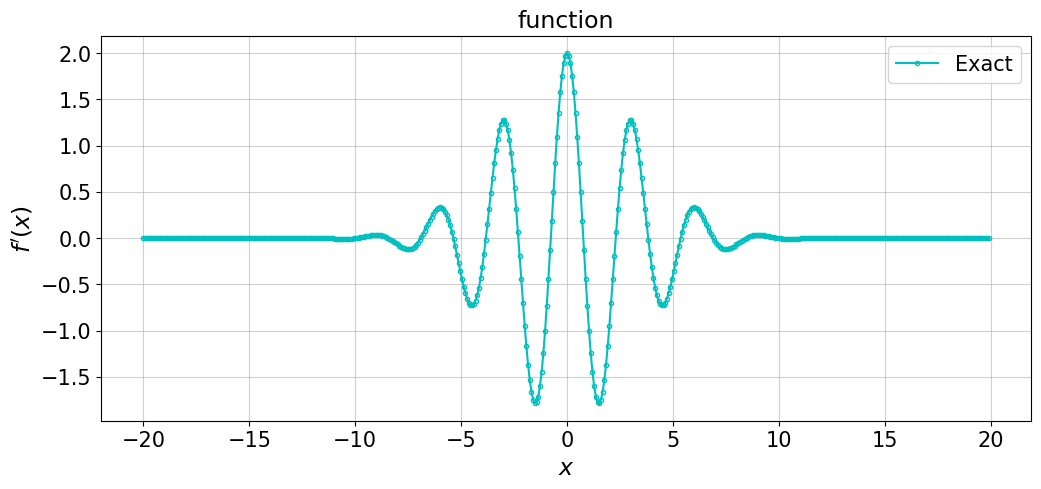

In [9]:
L=40
n=500
  
#create data
dx=L/n    
x=np.linspace(-L/2,L/2-dx,n)
fx=f(x)

#plot    
plt.figure()
plt.title('function')
plt.plot(x,fp(x),'.-c',label='Exact')
plt.xlabel(r'$x$')
plt.ylabel(r'$f^\prime(x)$')
plt.grid()
plt.legend(loc='upper right')
plt.show()



The central finite difference scheme to approximate the derivative $f'(x)$ of a function $f(x)$ is given as
$$f'_N(x) = \frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x} + \frac{\Delta x^2}{6} f'''(x) + \mathcal{O}(\Delta x^4) \ . $$

Considering two uncertain variables $x_1 = f(x+\Delta x)/(2\Delta x)$ and $x_2= f(x-\Delta x)/(2\Delta x)$, we get for the uncertainty of $y=x_1-x_2$

$$\varepsilon_y^2 =\left(\frac{ \varepsilon_x}{\Delta x}\right)^2  \left(\frac{\lambda f(x)}{f'(x)}\right)^2 \ .$$

Here, $\varepsilon_x$ is the relative error of the representation of a floating point number, i.e. the machine epsilon $\varepsilon_m\approx 2.22\cdot 10^{-16}$ for double precision numbers. $\lambda$ depends on the scheme, e.g. $\lambda=\sqrt{2}/2$ for a second-order scheme, and $\lambda=\sqrt{2}$ for a first-order scheme.

The leading term of the truncation error is given as

$$\varepsilon_d^2 = \left(\frac{\Delta x^2 f'''(x)}{6 f'(x)}\right)^2 \ .$$

The total error is the sum of the squares,

$$\varepsilon_\mathrm{tot}^2 = \varepsilon_y^2 + \varepsilon_d^2 \ . $$

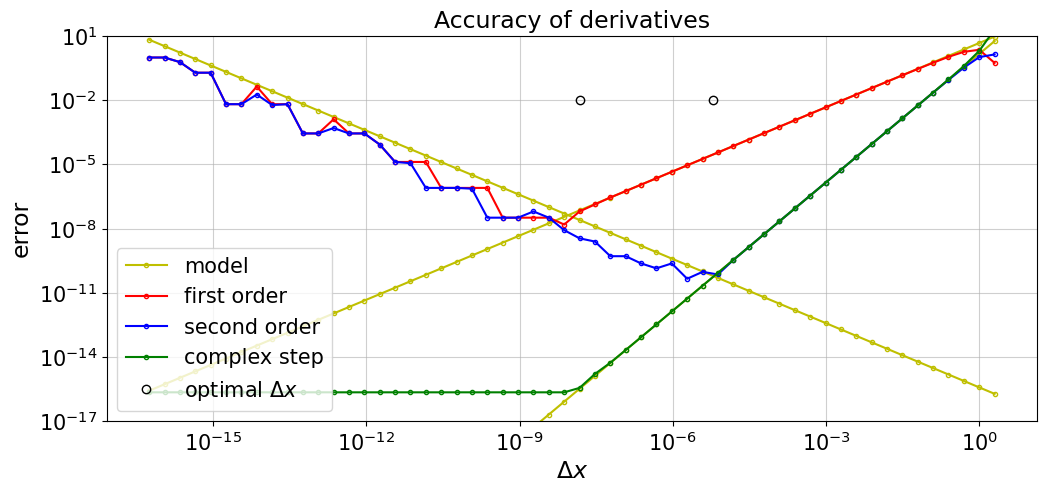

In [10]:
# arbitrary point
x=2.4

DX=[];E1=[]
E2=[];E3=[]

ET2=[];ED1=[];ED2=[]

epsm = np.finfo(float).eps
for i in range(-54,2):
   dx = 2**i

   df1 = (f(x+dx)-f(x))/dx
   e1 = abs(df1-fp(x))/abs(fp(x))
   E1=np.append(E1,e1)
    
   df2 = (f(x+dx)-f(x-dx))/2/dx
   e2 = abs(df2-fp(x))/abs(fp(x))
   E2=np.append(E2,e2)

   df3 = np.imag(f(x+1j*dx))/dx
   e3 = abs(df3-fp(x))/abs(fp(x))
   e3 = max (e3,np.finfo(float).eps)
   E3=np.append(E3,e3)

   ET2=np.append(ET2,epsm*abs(f(x)/(np.sqrt(2)*dx*abs(fp(x)))))
   ED1=np.append(ED1,dx*abs(fpp(x))/abs(2*abs(fp(x))))
   ED2=np.append(ED2,dx**2*abs(fppp(x))/abs(6*abs(fp(x))))

    
   DX=np.append(DX,dx)

etot1 = np.sqrt(ET2**2+ED1**2)
etot2 = np.sqrt(ET2**2+ED2**2)


#plot    
plt.figure()
plt.title('Accuracy of derivatives')
plt.loglog(DX,ET2,'.-y',label='model')
plt.loglog(DX,ED1,'.-y')
plt.loglog(DX,ED2,'.-y')
#plt.loglog(DX,etot1,'.-k')
#plt.loglog(DX,etot2,'.-k')
plt.loglog(DX,E1,'.-r',label='first order')
plt.loglog(DX,E2,'.-b',label='second order')
plt.loglog(DX,E3,'.-g',label='complex step')




plt.plot(epsm**(1/2),0.01,'ok',label="optimal $\Delta x$")
plt.plot(epsm**(1/3),0.01,'ok')
plt.xlabel('$\Delta x$')
plt.ylabel('error')
plt.ylim([1e-17,1e1])
plt.grid()
plt.legend(loc='lower left')
plt.show()


Based on simple geometrical arguments, you can derive an estimate for the ideal grid spacing $\Delta x$ for second order schemes ($\Delta x_\mathrm{opt} \approx \varepsilon_m^{1/3}$) and for first order schemes ($\Delta x_\mathrm{opt} \approx \varepsilon_m^{1/2}$), as indicated in the figure by a $\bullet$.

Note that there is also an interesting method to compute derivatives without taking differences, namely the so-called *complex step method*. This method is free from propagation errors, however its accuracy is limited by the machine epsilon as well (truncation error).

### References:

- Press, W. H. and Teukolsky, S. A., Numerical calculation of derivatives, Computers in Physics 5, pp. 68, 1991.

- Press, W. H., Teukolsky, S. A., Vetterling, W. T., and Flannery, B. P., Numerical Recipes: The Art of Scientific Computing, 3rd edition, Cambridge University Press, 2007.

- Goldberg, D., What every computer scientist should know about floating-point arithmetic, ACM Computing Surveys, 23:1, 1991.

- Martins, J. J., Sturdza, P. and Alonso, J. J., The complex-step derivative approximation. ACM
Transactions on Mathematical Software, Association for Computing Machinery, 2003, 29, pp. 245-262.